# Human Activity Recognition Classification

This code prepares accelerometer data for machine learning classification of human activities. To reduce the data dimensionality, we only select one of the tri-axial sensors (waist, wrist, and ankle) - in this case, the waist sensor. We also select only 1500 data points for each activity to make the dataset smaller and more manageable.

These activities include:
- walk_sidewalk
- upstairs
- downstairs
- jog_treadmill
- walk_treadmill
- walk_mixed

For the first round, you may keep the selections below, but the goal is that you experiment with more sensors and more data points to create a more accurate classifier.



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Step1: Dataset Preparation
The standardization produces a consistent format where each activity has the same representation length, making the dataset more balanced. The inserted zero-value segments create clear boundaries between activities, helping both visualization and algorithm training. This prepared dataset serves as a starting point, but you are encouraged to adjust the code as needed - try including data from multiple sensors (waist, wrist, and ankle) or increasing the number of data points per activity to potentially improve classification accuracy. As you experiment, observe how these changes affect both the computational requirements and the performance of your activity recognition models.

Note that this dataset contains data from a single user, but you should later test your trained model on data from other users to evaluate how well your classifier generalizes across different individuals with varying movement patterns.

**Data Info:**
1500 data points per activity:
- selected from the middle portion of when the data was collected.
- There is a separator between activities (value `200`). Need to remove

**Analysis of Labels**:
One hot encoding
- ['walk_sidewalk', 'upstairs', 'downstairs', 'walk_treadmill', 'jog_treadmill', 'walk_mixed']

**Idea**:
Transformer architecture with time series functionality:



In [14]:
from sklearn.preprocessing import OneHotEncoder
# Data Loading and Preparation
df = pd.read_csv('https://raw.githubusercontent.com/Har-Lab/HumanActivityData/refs/heads/main/data/labeled_activity_data/016_labeled.csv')


# Display all the unique activites
print(df['activity'].unique())
y_labels = df['activity']

# One hot encoding:
# Using pandas get_dummies
categorical_col = ['activity']

# Or using sklearn
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[categorical_cols])


['walk_sidewalk' 'upstairs' 'downstairs' 'walk_treadmill' 'jog_treadmill'
 'walk_mixed']


NameError: name 'categorical_cols' is not defined

In [ ]:
# Data Processing - Extract segments and add separators
columns_to_keep = ['time', 'waist_x', 'waist_y', 'waist_z', 'activity']
filtered_df = df[columns_to_keep].copy()
unique_activities = filtered_df['activity'].unique()
selected_chunks = []

for activity in unique_activities:
    activity_data = filtered_df[filtered_df['activity'] == activity].copy()
    middle_index = len(activity_data) // 2
    start_index = max(0, middle_index - 750)
    end_index = min(len(activity_data), middle_index + 750)
    selected_data = activity_data.iloc[start_index:end_index].copy()

    if len(selected_data) < 1500:
        print(f"Warning: Activity '{activity}' has only {len(selected_data)} data points (less than 1500)")

    selected_chunks.append(selected_data)

    # Create a separator of 200 rows with zeros between activities
    separator = pd.DataFrame({
        'time': [selected_data.iloc[-1]['time']] * 200,  # Use the last timestamp from previous activity
        'waist_x': [0] * 200,  # Set x-axis values to zero
        'waist_y': [0] * 200,  # Set y-axis values to zero
        'waist_z': [0] * 200,  # Set z-axis values to zero
       'activity': ['separator'] * 200  # Label these rows as 'separator'
    })
    selected_chunks.append(separator)  # Add this separator to our collection.

# Data Consolidation
final_df = pd.concat(selected_chunks[:-1])
final_df.reset_index(drop=True, inplace=True)
print(final_df.head())

# Visualization
plt.figure(figsize=(15, 6))
for column in ['waist_x', 'waist_y', 'waist_z']:
    plt.plot(final_df.index, final_df[column], label=column)
plt.legend()
plt.title('Waist Sensor Data with Activity Separators')
plt.xlabel('Index')
plt.ylabel('Acceleration')
plt.grid(True)
plt.show()

# Results and Export
final_df.to_csv('processed_activity_data.csv', index=False)
print("\nTotal rows in final dataset:", len(final_df))
activity_counts = final_df['activity'].value_counts()
print("\nActivity distribution:")
print(activity_counts)

### Exercise 1: Modify the Data Selection

Modify the code above to include data from additional sensors. Instead of just using the waist sensor, include either the wrist or ankle sensor (or both).

In [ ]:
# YOUR CODE HERE
# 1. Modify the columns_to_keep list to include additional sensor data
# 2. Update the separator creation code to handle the new columns
# 3. Re-run the visualization to see how the patterns differ with multiple sensors

## Analyzing Activity Patterns

Take some time to carefully examine the plot generated by the code. Pay attention to the distinct patterns visible for each activity:

1. How do different types of activities look visually in the acceleration data?
2. Compare jogging to walking - what differences do you notice in amplitude, frequency, and pattern?
3. Look at the different types of walking (treadmill walking vs. sidewalk walking) - can you spot any differences?
4. Which activities appear most similar to each other? Which are most distinct?

Understanding these visual patterns will help you appreciate how machine learning algorithms can learn to distinguish between activities, and why feature extraction becomes important for improving classification accuracy.

# Step 2: Basic Classification Without Feature Extraction

## Understanding Classification Metrics

When evaluating our activity recognition models, we'll use several key metrics:

**Accuracy**: The proportion of correctly classified activities out of all predictions. While intuitive, accuracy alone can be misleading when classes are imbalanced (e.g., if we have many more walking samples than jogging samples).

**Precision**: For a specific activity (like "jogging"), precision measures how many of the samples our model labeled as "jogging" were actually jogging. High precision means fewer false positives—the model rarely mistakes other activities for jogging.

**Recall**: For a specific activity, recall measures how many of the actual jogging samples were correctly identified by our model. High recall means fewer false negatives—the model rarely misses instances of jogging.

**F1 score**: The harmonic mean of precision and recall, providing a single metric that balances both concerns. This is especially useful for imbalanced classes, where we want to ensure the model both correctly identifies activities when they occur (high recall) and doesn't falsely identify them when they don't (high precision).

**Support**: The number of actual occurrences of each class in your test dataset. This helps you understand how many samples were available for testing each activity type.

In our activity recognition context, these metrics help us understand if our model can reliably distinguish between similar activities (like different types of walking) and whether it performs consistently across all activity types.

In [3]:
# Load the processed data
df = pd.read_csv('processed_activity_data.csv')

# Remove separator rows
df = df[df['activity'] != 'separator']

# Split features and target
X = df[['waist_x', 'waist_y', 'waist_z']]
y = df['activity']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest classifier
print("Training Random Forest on raw accelerometer data...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

Training Random Forest on raw accelerometer data...


RandomForestClassifier(random_state=42)


Classification Report (Raw Data):
                precision    recall  f1-score   support

    downstairs       0.48      0.42      0.45       450
 jog_treadmill       0.81      0.83      0.82       450
      upstairs       0.52      0.56      0.54       450
    walk_mixed       0.47      0.49      0.48       450
 walk_sidewalk       0.46      0.43      0.45       450
walk_treadmill       0.43      0.46      0.45       450

      accuracy                           0.53      2700
     macro avg       0.53      0.53      0.53      2700
  weighted avg       0.53      0.53      0.53      2700



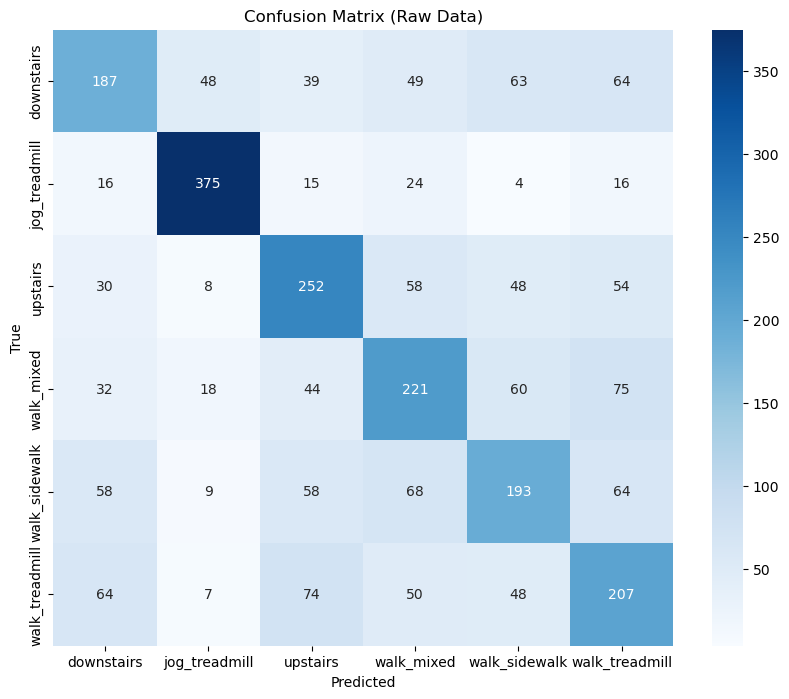

In [4]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
print("\nClassification Report (Raw Data):")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Raw Data)')
plt.show()

### Exercise 2: Try a Different Classifier

Implement a different classifier and compare its performance to Random Forest.

In [15]:
# YOUR CODE HERE
# 1. Import a different classifier (such as SVC, KNeighborsClassifier, etc.)
# 2. Train it on the same data
# 3. Evaluate and compare the results to Random Forest
#
# Example:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))

                precision    recall  f1-score   support

    downstairs       0.47      0.30      0.37       450
 jog_treadmill       0.84      0.80      0.82       450
      upstairs       0.43      0.62      0.50       450
    walk_mixed       0.45      0.22      0.30       450
 walk_sidewalk       0.43      0.43      0.43       450
walk_treadmill       0.33      0.48      0.39       450

      accuracy                           0.48      2700
     macro avg       0.49      0.48      0.47      2700
  weighted avg       0.49      0.48      0.47      2700



# Reflection on Initial Results

Before proceeding to more advanced techniques, consider these questions about our basic model:

1. What does a 50% accuracy tell us about using raw accelerometer data for activity recognition?

2. Looking at the confusion matrix, which activities are most commonly confused with each other? Why might this be happening?

3. Our model is only slightly better than random guessing for 6 classes. What limitations of using raw accelerometer values might explain this performance?

4. What specific aspects of human movements might not be captured when using only the direct x, y, z acceleration values from the waist sensor?

Take a moment to record your hypotheses - after implementing feature extraction, we'll see if your predictions about potential improvements were correct.

# Step 3: Feature Extraction and Improved Classification

## Understanding Changes in Sample Size After Feature Extraction

You'll notice that after feature extraction, the "support" numbers in the classification report are much smaller than in our first model. This is normal and expected due to our window-based feature extraction approach.

## Why is there less data after feature extraction?

* **Raw data approach**: Each individual accelerometer reading (single timestamp) counts as one sample, so with 1500 points per activity, we have 1500 samples per activity.

* **Feature extraction approach**: We use a sliding window (size=100, overlap=50) to group consecutive readings together. For each window, we calculate statistical features (mean, standard deviation, etc.) and treat the entire window as a single sample.

* **Sample reduction calculation**: With 1500 original data points and windows of 100 points moving forward by 50 points each time, we get approximately (1500-100)/(100-50) + 1 = 29 samples per activity.

This reduction is beneficial because:
1. Each sample now contains rich statistical information about the movement patterns
2. The classifier can learn from these meaningful features rather than trying to make sense of individual readings
3. The model becomes more robust to noise and small variations in the raw data

Extracting time and frequency domain features...
Training Random Forest on extracted features...

Classification Report (With Feature Extraction):
                precision    recall  f1-score   support

    downstairs       1.00      0.75      0.86         8
 jog_treadmill       1.00      1.00      1.00         8
      upstairs       1.00      0.67      0.80         9
    walk_mixed       0.69      1.00      0.82         9
 walk_sidewalk       1.00      1.00      1.00         9
walk_treadmill       0.89      1.00      0.94         8

      accuracy                           0.90        51
     macro avg       0.93      0.90      0.90        51
  weighted avg       0.93      0.90      0.90        51



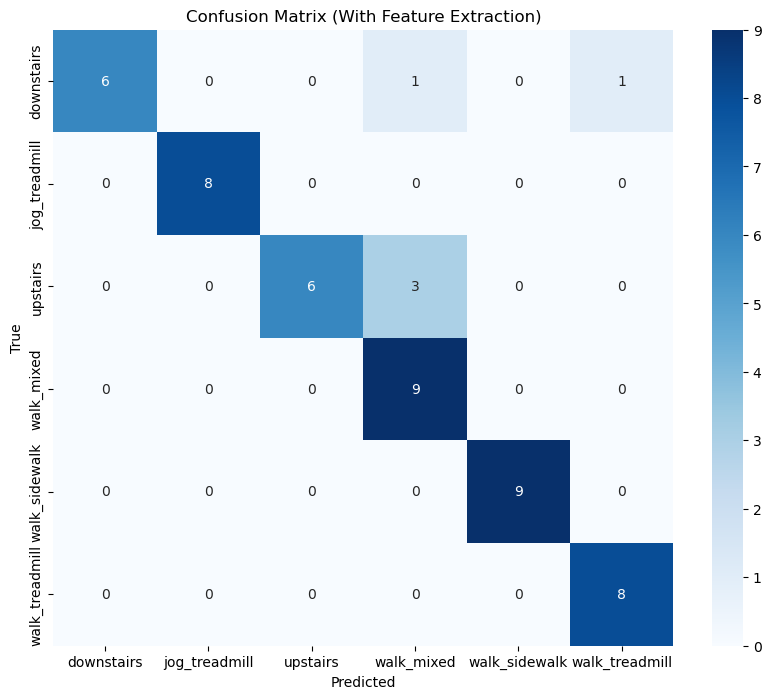

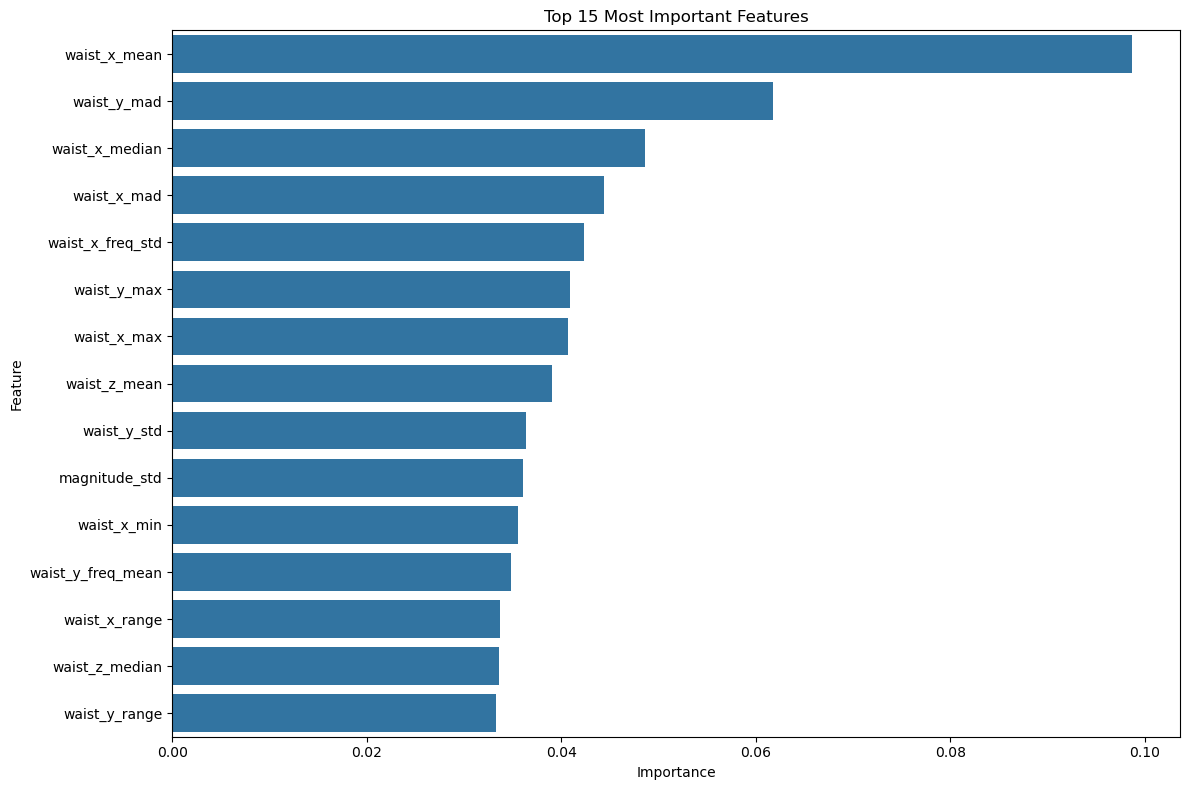

In [5]:
from scipy import stats
from scipy.fft import fft

# Function to extract time and frequency domain features
def extract_features(data, window_size=100, overlap=50):
    """Extract time and frequency domain features from accelerometer data"""
    features = []
    labels = []

    # Get unique activities (excluding separator activity)
    activities = data[data['activity'] != 'separator']['activity'].unique()

    for activity in activities:
        # Get data for this activity
        activity_data = data[data['activity'] == activity].copy()

        # Sliding window with overlap
        step = window_size - overlap
        for i in range(0, len(activity_data) - window_size, step):
            window = activity_data.iloc[i:i+window_size]

            # Extract features for each axis
            feature_row = {}

            for axis in ['waist_x', 'waist_y', 'waist_z']:
                values = window[axis].values

                # Time domain features
                feature_row[f'{axis}_mean'] = np.mean(values)
                feature_row[f'{axis}_std'] = np.std(values)
                feature_row[f'{axis}_min'] = np.min(values)
                feature_row[f'{axis}_max'] = np.max(values)
                feature_row[f'{axis}_range'] = np.max(values) - np.min(values)
                feature_row[f'{axis}_median'] = np.median(values)
                feature_row[f'{axis}_mad'] = np.mean(np.abs(values - np.mean(values)))  # Mean absolute deviation
                feature_row[f'{axis}_skew'] = stats.skew(values)
                feature_row[f'{axis}_kurtosis'] = stats.kurtosis(values)

                # Frequency domain features
                fft_values = fft(values)
                fft_magnitude = np.abs(fft_values)[:window_size//2]

                feature_row[f'{axis}_freq_max'] = np.argmax(fft_magnitude)
                feature_row[f'{axis}_freq_mean'] = np.mean(fft_magnitude)
                feature_row[f'{axis}_freq_std'] = np.std(fft_magnitude)
                feature_row[f'{axis}_freq_energy'] = np.sum(fft_magnitude**2) / window_size

            # Add additional features using multiple axes
            waist_x = window['waist_x'].values
            waist_y = window['waist_y'].values
            waist_z = window['waist_z'].values

            # Magnitude
            magnitude = np.sqrt(waist_x**2 + waist_y**2 + waist_z**2)
            feature_row['magnitude_mean'] = np.mean(magnitude)
            feature_row['magnitude_std'] = np.std(magnitude)

            features.append(feature_row)
            labels.append(activity)

    # Convert to DataFrame
    feature_df = pd.DataFrame(features)

    return feature_df, pd.Series(labels)

# Extract features
print("Extracting time and frequency domain features...")
X_features, y_features = extract_features(df)

# Split into training and testing sets
X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(
    X_features, y_features, test_size=0.3, random_state=42, stratify=y_features)

# Train a Random Forest classifier on the extracted features
print("Training Random Forest on extracted features...")
rf_features_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_features_model.fit(X_train_features, y_train_features)

# Evaluate the model
y_pred_features = rf_features_model.predict(X_test_features)
print("\nClassification Report (With Feature Extraction):")
print(classification_report(y_test_features, y_pred_features))

# Plot confusion matrix
cm_features = confusion_matrix(y_test_features, y_pred_features)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_features, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_features_model.classes_,
            yticklabels=rf_features_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (With Feature Extraction)')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_features.columns,
    'Importance': rf_features_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

### Exercise 3: Add New Features

Add at least two new features to the extract_features function. Document what these features represent and why you think they might be useful for activity classification.

In [6]:
# YOUR CODE HERE
# 1. Create a modified version of the extract_features function
# 2. Add at least two new time or frequency domain features
# 3. Train and evaluate a model with these new features
# 4. Compare the results to the original feature set

def extract_features_enhanced(data, window_size=100, overlap=50):
    """Extract enhanced time and frequency domain features from accelerometer data"""
    features = []
    labels = []

    # Get unique activities (excluding separator)
    activities = data[data['activity'] != 'separator']['activity'].unique()

    for activity in activities:
        activity_data = data[data['activity'] == activity].copy()

        # Sliding window implementation
        step = window_size - overlap
        for i in range(0, len(activity_data) - window_size, step):
            window = activity_data.iloc[i:i+window_size]

            feature_row = {}

            for axis in ['waist_x', 'waist_y', 'waist_z']:
                values = window[axis].values

                # Include original features
                feature_row[f'{axis}_mean'] = np.mean(values)
                feature_row[f'{axis}_std'] = np.std(values)
                # ... (include other original features)

                # TODO: Add your new features here
                # Example:
                # feature_row[f'{axis}_iqr'] = np.percentile(values, 75) - np.percentile(values, 25)
                # feature_row[f'{axis}_zero_crossings'] = np.sum(np.diff(np.signbit(values)))

            # Include original combined features
            waist_x = window['waist_x'].values
            waist_y = window['waist_y'].values
            waist_z = window['waist_z'].values

            magnitude = np.sqrt(waist_x**2 + waist_y**2 + waist_z**2)
            feature_row['magnitude_mean'] = np.mean(magnitude)
            feature_row['magnitude_std'] = np.std(magnitude)

            # TODO: Add new combined features

            features.append(feature_row)
            labels.append(activity)

    return pd.DataFrame(features), pd.Series(labels)

# Test your enhanced feature extraction
# X_features_enhanced, y_features_enhanced = extract_features_enhanced(df)
# ... (train and evaluate your model)

### Exercise 4: Feature Selection

Use only the top N most important features identified in the feature importance analysis, and see how this affects accuracy.

In [ ]:
# YOUR CODE HERE
# 1. Get the top N most important features
# 2. Create a new dataset with only these features
# 3. Train and evaluate a model on this reduced feature set
# 4. Compare with the full feature set results

# Example:
# n_features = 10  # You can experiment with different values
# top_features = feature_importance.head(n_features)['Feature'].values
# X_train_selected = X_train_features[top_features]
# X_test_selected = X_test_features[top_features]
#
# rf_selected_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_selected_model.fit(X_train_selected, y_train_features)
# y_pred_selected = rf_selected_model.predict(X_test_selected)
#
# print("\nClassification Report (Selected Features):")
# print(classification_report(y_test_features, y_pred_selected))

### Exercise 5: Window Size Experimentation

Experiment with different window sizes and overlap values to see how they affect the classification performance.

In [ ]:
# YOUR CODE HERE
# 1. Test different window sizes (e.g., 50, 100, 200)
# 2. Test different overlap percentages (e.g., 25%, 50%, 75%)
# 3. Compare the results and discuss the tradeoffs

# Example:
# window_sizes = [50, 100, 200]
# overlaps = [0.25, 0.5, 0.75]
#
# results = {}
#
# for window_size in window_sizes:
#     for overlap_pct in overlaps:
#         overlap = int(window_size * overlap_pct)
#         # Extract features with current parameters
#         X_features_test, y_features_test = extract_features(df, window_size=window_size, overlap=overlap)
#
#         # Train and test
#         # ... (split data, train model, evaluate)
#
#         # Store results
#         results[f"window_{window_size}_overlap_{overlap_pct}"] = accuracy_score  # or other metrics
#
# # Analyze and visualize results
# # ...

# Improved Classification with Feature Extraction

Compare the classification results above with the previous model. You should notice an improvement in accuracy. This demonstrates the importance of feature extraction in human activity recognition.

The features we extracted include:

1. **Time domain features**: mean, standard deviation, min, max, range, median, mean absolute deviation, skewness, and kurtosis.
2. **Frequency domain features**: dominant frequency, mean frequency magnitude, frequency standard deviation, and spectral energy.
3. **Combined features**: magnitude of acceleration across all three axes.


In [ ]:
# Experiments to Try:

#1. Add more sensors: Modify the code to include data from wrist and ankle sensors.
#2. Try different classifiers: Compare Random Forest with SVM, KNN, or Neural Networks.
#3. Feature selection: Use the feature importance plot to select the most relevant features.
# 4. Adjust window size: Try different window sizes for feature extraction.
# 5. Add more features: Research and implement additional time or frequency domain features.
#6. Cross-user testing: Train on one user and test on another to evaluate generalization.

# Document your experiments and findings. Which combination of sensors, features, and algorithms gives the best performance?

# Final Exercise: Design Your Own Improvement

Based on what you've learned, design and implement your own improvement to the activity recognition system. This could involve:

1. Combining multiple classifiers in an ensemble
2. Implementing a more sophisticated feature selection method
3. Creating a real-time activity prediction system
4. Designing a cross-user normalization approach
5. Anything else you think might improve performance!

Document your approach, implementation, and results.